In [2]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split #交叉验证
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import confusion_matrix
from numpy.random import permutation

import math
import warnings

warnings.filterwarnings('ignore')

#12个特征

In [3]:
#max,min,var,mean (xyz),共12个特征
df=pd.read_csv('all_data_rad_pitch.csv')
cols=['max_Ax','var_Ax','mean_Ax','max_Ay',
      'var_Ay','mean_Ay','max_Az','var_Az','mean_Az',
      'max_pitch','var_pitch','mean_pitch','label']
df=df[cols]

adl_df=df[df['label']==0]
fall_df=df[df['label']==1]

random_indices = permutation(adl_df.index)  #随机打乱index,得到的是一个index的序列
test_split = math.floor(len(adl_df)*0.3)  #math.floor() 向下取整

# len(random_indices)
adl_df_test = adl_df.loc[random_indices[0:test_split]]
# Train set with 70% of the items.
adl_df_train = adl_df.loc[random_indices[test_split:]]

# Now we prepare the sets of Falls
random_indices = permutation(fall_df.index)
test_split = math.floor(len(fall_df)*0.3)

fall_df_test = fall_df.loc[random_indices[0:test_split]]
fall_df_train = fall_df.loc[random_indices[test_split:]]

print("Total ADL: " + str(len(adl_df)))
print("Total Falls: " + str(len(fall_df)))
print("Train Falls: "+ str(len(fall_df_train)))
print("Train ADL: "+ str(len(adl_df_train)))
print("Test Falls: "+ str(len(fall_df_test)))
print("Test ADL: "+ str(len(adl_df_test)))

#test_data
frames = [adl_df_test, fall_df_test]
test_data = pd.concat(frames) #默认axis=0

#train_data
frames = [adl_df_train, fall_df_train]
train_data = pd.concat(frames) #默认axis=0

#train_data.describe()
y_train=train_data.label
X_train=train_data.drop('label',axis=1)

y_test=test_data.label
X_test=test_data.drop('label',axis=1)

Total ADL: 2702
Total Falls: 1798
Train Falls: 1259
Train ADL: 1892
Test Falls: 539
Test ADL: 810


RF+CV

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  3.34s/it]


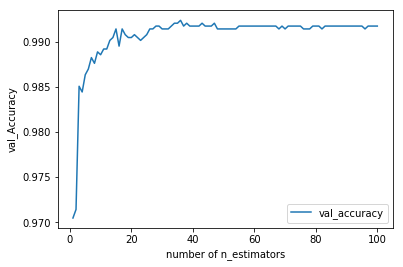

best val Accuracy: 0.9923819378056257
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=36, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [4]:
val_accuracy = []  #交叉验证得分
bestAcc = 0.0  #最好的模型的交叉验证得分
best_model=None
xList=np.arange(1,101)
for n in tqdm(xList):
    forest = RandomForestClassifier(n_estimators=n, random_state=0)
    #交叉验证的精确度
    s=np.mean(cross_val_score(forest, X_train, y_train, cv=10))
    val_accuracy.append(s)
    if s>bestAcc:
        bestAcc=s
        best_model=forest
        
plt.figure()
plt.plot(xList,val_accuracy,label='val_accuracy')
plt.legend()
plt.xlabel('number of n_estimators')
plt.ylabel('val_Accuracy')
plt.show();

print('best val Accuracy:',bestAcc)
print(best_model)

In [7]:
#找到最好的模型训练 X_train,y_train
RF=best_model
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=36, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [8]:
#训练数据的 混淆矩阵
predictions = RF.predict(X_train)

cm = confusion_matrix(y_train, predictions, labels=[0,1])
print(cm)
TN, FP, FN, TP = cm.ravel()

# SENSITIVITY = TP / (TP + FN)
Sensitivity = TP / (TP + FN)
print("Sensitivity = "+ str(Sensitivity))

# SPECIFICITY = TN / (FP + TN)
Specificity = TN / (FP + TN)
print("Specificity = "+ str(Specificity))

# Precision = TP / (TP + FP)
Precision = TP / (TP + FP)
print("Precision = "+ str(Precision))

# Accuracy = (TP + TN) / (TP + FP + TN + FN)
Accuracy = (TP + TN) / (TP + FP + TN + FN)
print("Accuracy = "+ str(Accuracy))

[[1892    0]
 [   0 1259]]
Sensitivity = 1.0
Specificity = 1.0
Precision = 1.0
Accuracy = 1.0


In [9]:
#测试数据的 混淆矩阵
predictions = RF.predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=[0,1])
print(cm)
TN, FP, FN, TP = cm.ravel()

# SENSITIVITY = TP / (TP + FN)
Sensitivity = TP / (TP + FN)
print("Sensitivity = "+ str(Sensitivity))

# SPECIFICITY = TN / (FP + TN)
Specificity = TN / (FP + TN)
print("Specificity = "+ str(Specificity))

# Precision = TP / (TP + FP)
Precision = TP / (TP + FP)
print("Precision = "+ str(Precision))

# Accuracy = (TP + TN) / (TP + FP + TN + FN)
Accuracy = (TP + TN) / (TP + FP + TN + FN)
print("Accuracy = "+ str(Accuracy))

[[801   9]
 [  9 530]]
Sensitivity = 0.9833024118738405
Specificity = 0.9888888888888889
Precision = 0.9833024118738405
Accuracy = 0.9866567828020756


#16维特征 ,添加pitch的

In [3]:
#max,min,var,mean (xyz),共12个特征
df=pd.read_csv('all_data.csv')
cols=['max_Ax','min_Ax','var_Ax','mean_Ax','max_Ay','min_Ay',
      'var_Ay','mean_Ay','max_Az','min_Az','var_Az','mean_Az',
      'max_pitch','min_pitch','var_pitch','mean_pitch','label']
df=df[cols]

adl_df=df[df['label']==0]
fall_df=df[df['label']==1]

random_indices = permutation(adl_df.index)  #随机打乱index,得到的是一个index的序列
test_split = math.floor(len(adl_df)*0.3)  #math.floor() 向下取整

# len(random_indices)
adl_df_test = adl_df.loc[random_indices[0:test_split]]
# Train set with 70% of the items.
adl_df_train = adl_df.loc[random_indices[test_split:]]

# Now we prepare the sets of Falls
random_indices = permutation(fall_df.index)
test_split = math.floor(len(fall_df)*0.3)

fall_df_test = fall_df.loc[random_indices[0:test_split]]
fall_df_train = fall_df.loc[random_indices[test_split:]]

print("Total ADL: " + str(len(adl_df)))
print("Total Falls: " + str(len(fall_df)))
print("Train Falls: "+ str(len(fall_df_train)))
print("Train ADL: "+ str(len(adl_df_train)))
print("Test Falls: "+ str(len(fall_df_test)))
print("Test ADL: "+ str(len(adl_df_test)))

#test_data
frames = [adl_df_test, fall_df_test]
test_data = pd.concat(frames) #默认axis=0

#train_data
frames = [adl_df_train, fall_df_train]
train_data = pd.concat(frames) #默认axis=0

#train_data.describe()
y_train=train_data.label
X_train=train_data.drop('label',axis=1)

y_test=test_data.label
X_test=test_data.drop('label',axis=1)

#RF不需要特征缩放

Total ADL: 2702
Total Falls: 1798
Train Falls: 1259
Train ADL: 1892
Test Falls: 539
Test ADL: 810


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:24<00:00,  2.65s/it]


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'number of n_estimators')

Text(0, 0.5, 'val_Accuracy')

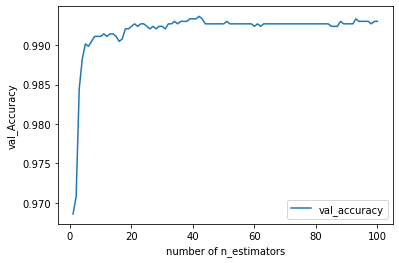

best val Accuracy: 0.9936507808530708
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=42, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [4]:
val_accuracy = []  #交叉验证得分
bestAcc = 0.0  #最好的模型的交叉验证得分
best_model=None
xList=np.arange(1,101)
for n in tqdm(xList):
    forest = RandomForestClassifier(n_estimators=n, random_state=0)
    #交叉验证的精确度
    s=np.mean(cross_val_score(forest, X_train, y_train, cv=10))
    val_accuracy.append(s)
    if s>bestAcc:
        bestAcc=s
        best_model=forest
        
plt.figure()
plt.plot(xList,val_accuracy,label='val_accuracy')
plt.legend()
plt.xlabel('number of n_estimators')
plt.ylabel('val_Accuracy')
plt.show();

print('best val Accuracy:',bestAcc)
print(best_model)

In [5]:
#找到最好的模型训练 X_train,y_train
RF=best_model
#RF=RandomForestClassifier(n_estimators=39, random_state=0)
#RF=RandomForestClassifier()
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=42, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [6]:
#训练数据的 混淆矩阵
predictions = RF.predict(X_train)

cm = confusion_matrix(y_train, predictions, labels=[0,1])
print(cm)
TN, FP, FN, TP = cm.ravel()

# SENSITIVITY = TP / (TP + FN)
Sensitivity = TP / (TP + FN)
print("Sensitivity = "+ str(Sensitivity))

# SPECIFICITY = TN / (FP + TN)
Specificity = TN / (FP + TN)
print("Specificity = "+ str(Specificity))

# Precision = TP / (TP + FP)
Precision = TP / (TP + FP)
print("Precision = "+ str(Precision))

# Accuracy = (TP + TN) / (TP + FP + TN + FN)
Accuracy = (TP + TN) / (TP + FP + TN + FN)
print("Accuracy = "+ str(Accuracy))

[[1892    0]
 [   0 1259]]
Sensitivity = 1.0
Specificity = 1.0
Precision = 1.0
Accuracy = 1.0


In [7]:
#测试数据的 混淆矩阵
predictions = RF.predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=[0,1])
print(cm)
TN, FP, FN, TP = cm.ravel()

# SENSITIVITY = TP / (TP + FN)
Sensitivity = TP / (TP + FN)
print("Sensitivity = "+ str(Sensitivity))

# SPECIFICITY = TN / (FP + TN)
Specificity = TN / (FP + TN)
print("Specificity = "+ str(Specificity))

# Precision = TP / (TP + FP)
Precision = TP / (TP + FP)
print("Precision = "+ str(Precision))

# Accuracy = (TP + TN) / (TP + FP + TN + FN)
Accuracy = (TP + TN) / (TP + FP + TN + FN)
print("Accuracy = "+ str(Accuracy))

[[802   8]
 [  5 534]]
Sensitivity = 0.9907235621521335
Specificity = 0.9901234567901235
Precision = 0.985239852398524
Accuracy = 0.9903632320237212


#27个特征

In [536]:
df=pd.read_csv('all_data.csv')
cols=['label', 'max_Ax', 'min_Ax', 'range_Ax', 'kurtosis_Ax', 'skewness_Ax',
       'max_Ay', 'min_Ay', 'range_Ay', 'kurtosis_Ay', 'skewness_Ay', 'max_Az',
       'min_Az', 'range_Az', 'kurtosis_Az', 'skewness_Az', 'max_SVM',
       'range_SVM', 'kurtosis_SVM', 'skewness_SVM', 'max_HOR', 'range_HOR',
       'kurtosis_HOR', 'skewness_HOR', 'max_VER', 'range_VER', 'kurtosis_VER',
       'skewness_VER']

df=df[cols]

adl_df=df[df['label']==0]
fall_df=df[df['label']==1]

random_indices = permutation(adl_df.index)  #随机打乱index,得到的是一个index的序列
test_split = math.floor(len(adl_df)*0.3)  #math.floor() 向下取整

# len(random_indices)
adl_df_test = adl_df.loc[random_indices[0:test_split]]
# Train set with 70% of the items.
adl_df_train = adl_df.loc[random_indices[test_split:]]

# Now we prepare the sets of Falls
random_indices = permutation(fall_df.index)
test_split = math.floor(len(fall_df)*0.3)

fall_df_test = fall_df.loc[random_indices[0:test_split]]
fall_df_train = fall_df.loc[random_indices[test_split:]]

print("Total ADL: " + str(len(adl_df)))
print("Total Falls: " + str(len(fall_df)))
print("Train Falls: "+ str(len(fall_df_train)))
print("Train ADL: "+ str(len(adl_df_train)))
print("Test Falls: "+ str(len(fall_df_test)))
print("Test ADL: "+ str(len(adl_df_test)))

#test_data
frames = [adl_df_test, fall_df_test]
test_data = pd.concat(frames) #默认axis=0

#train_data
frames = [adl_df_train, fall_df_train]
train_data = pd.concat(frames) #默认axis=0

#train_data.describe()
y_train=train_data.label
X_train=train_data.drop('label',axis=1)

y_test=test_data.label
X_test=test_data.drop('label',axis=1)

#特征缩放
#scaler=StandardScaler()
#X_train=scaler.fit_transform(X_train)
#X_test=scaler.fit_transform(X_test)

Total ADL: 2702
Total Falls: 1798
Train Falls: 1259
Train ADL: 1892
Test Falls: 539
Test ADL: 810


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:47<00:00,  3.48s/it]


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'number of n_estimators')

Text(0, 0.5, 'val_Accuracy')

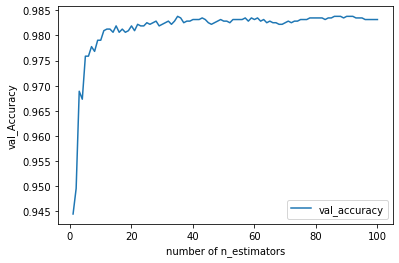

best val Accuracy: 0.9838155131439015
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [537]:
val_accuracy = []  #交叉验证得分
bestAcc = 0.0  #最好的模型的交叉验证得分
best_model=None
xList=np.arange(1,101)
for n in tqdm(xList):
    forest = RandomForestClassifier(n_estimators=n, random_state=0)
    #交叉验证的精确度
    s=np.mean(cross_val_score(forest, X_train, y_train, cv=10))
    val_accuracy.append(s)
    if s>bestAcc:
        bestAcc=s
        best_model=forest
        
plt.figure()
plt.plot(xList,val_accuracy,label='val_accuracy')
plt.legend()
plt.xlabel('number of n_estimators')
plt.ylabel('val_Accuracy')
plt.show();

print('best val Accuracy:',bestAcc)
print(best_model)

In [538]:
#找到最好的模型训练 X_train,y_train
RF=best_model
#RF = RandomForestClassifier(n_estimators=98, random_state=0)
#RF = RandomForestClassifier()
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [539]:
#训练数据的 混淆矩阵
predictions = RF.predict(X_train)

cm = confusion_matrix(y_train, predictions, labels=[0,1])
print(cm)
TN, FP, FN, TP = cm.ravel()

# SENSITIVITY = TP / (TP + FN)
Sensitivity = TP / (TP + FN)
print("Sensitivity = "+ str(Sensitivity))

# SPECIFICITY = TN / (FP + TN)
Specificity = TN / (FP + TN)
print("Specificity = "+ str(Specificity))

# Precision = TP / (TP + FP)
Precision = TP / (TP + FP)
print("Precision = "+ str(Precision))

# Accuracy = (TP + TN) / (TP + FP + TN + FN)
Accuracy = (TP + TN) / (TP + FP + TN + FN)
print("Accuracy = "+ str(Accuracy))

[[1892    0]
 [   0 1259]]
Sensitivity = 1.0
Specificity = 1.0
Precision = 1.0
Accuracy = 1.0


In [540]:
#测试数据的 混淆矩阵
predictions = RF.predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=[0,1])
print(cm)
TN, FP, FN, TP = cm.ravel()
# SENSITIVITY = TP / (TP + FN)
Sensitivity = TP / (TP + FN)
print("Sensitivity = "+ str(Sensitivity))

# SPECIFICITY = TN / (FP + TN)
Specificity = TN / (FP + TN)
print("Specificity = "+ str(Specificity))

# Precision = TP / (TP + FP)
Precision = TP / (TP + FP)
print("Precision = "+ str(Precision))

# Accuracy = (TP + TN) / (TP + FP + TN + FN)
Accuracy = (TP + TN) / (TP + FP + TN + FN)
print("Accuracy = "+ str(Accuracy))

[[794  16]
 [ 13 526]]
Sensitivity = 0.9758812615955473
Specificity = 0.980246913580247
Precision = 0.9704797047970479
Accuracy = 0.9785025945144552


In [541]:
#joblib.dump(RF,'RF_2.pkl')

['RF_2.pkl']

#31维特征,添加了pitch

In [9]:
df=pd.read_csv('all_data.csv')
cols=['label', 'max_Ax', 'min_Ax', 'range_Ax', 'kurtosis_Ax', 'skewness_Ax',
       'max_Ay', 'min_Ay', 'range_Ay', 'kurtosis_Ay', 'skewness_Ay', 'max_Az',
       'min_Az', 'range_Az', 'kurtosis_Az', 'skewness_Az', 'max_SVM',
       'range_SVM', 'kurtosis_SVM', 'skewness_SVM', 'max_HOR', 'range_HOR',
       'kurtosis_HOR', 'skewness_HOR', 'max_VER', 'range_VER', 'kurtosis_VER',
       'skewness_VER','max_pitch','min_pitch','var_pitch','mean_pitch']

df=df[cols]

adl_df=df[df['label']==0]
fall_df=df[df['label']==1]

random_indices = permutation(adl_df.index)  #随机打乱index,得到的是一个index的序列
test_split = math.floor(len(adl_df)*0.3)  #math.floor() 向下取整

# len(random_indices)
adl_df_test = adl_df.loc[random_indices[0:test_split]]
# Train set with 70% of the items.
adl_df_train = adl_df.loc[random_indices[test_split:]]

# Now we prepare the sets of Falls
random_indices = permutation(fall_df.index)
test_split = math.floor(len(fall_df)*0.3)

fall_df_test = fall_df.loc[random_indices[0:test_split]]
fall_df_train = fall_df.loc[random_indices[test_split:]]

print("Total ADL: " + str(len(adl_df)))
print("Total Falls: " + str(len(fall_df)))
print("Train Falls: "+ str(len(fall_df_train)))
print("Train ADL: "+ str(len(adl_df_train)))
print("Test Falls: "+ str(len(fall_df_test)))
print("Test ADL: "+ str(len(adl_df_test)))

#test_data
frames = [adl_df_test, fall_df_test]
test_data = pd.concat(frames) #默认axis=0

#train_data
frames = [adl_df_train, fall_df_train]
train_data = pd.concat(frames) #默认axis=0

#train_data.describe()
y_train=train_data.label
X_train=train_data.drop('label',axis=1)

y_test=test_data.label
X_test=test_data.drop('label',axis=1)

Total ADL: 2702
Total Falls: 1798
Train Falls: 1259
Train ADL: 1892
Test Falls: 539
Test ADL: 810


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:18<00:00,  3.18s/it]


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'number of n_estimators')

Text(0, 0.5, 'val_Accuracy')

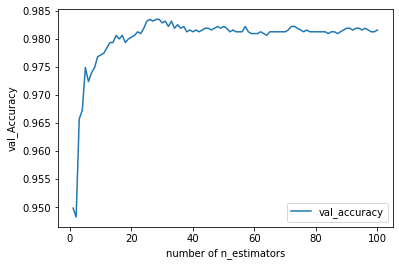

best val Accuracy: 0.9834990574476989
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=29, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [10]:
val_accuracy = []  #交叉验证得分
bestAcc = 0.0  #最好的模型的交叉验证得分
best_model=None
xList=np.arange(1,101)
for n in tqdm(xList):
    forest = RandomForestClassifier(n_estimators=n, random_state=0)
    #交叉验证的精确度
    s=np.mean(cross_val_score(forest, X_train, y_train, cv=10))
    val_accuracy.append(s)
    if s>bestAcc:
        bestAcc=s
        best_model=forest
        
plt.figure()
plt.plot(xList,val_accuracy,label='val_accuracy')
plt.legend()
plt.xlabel('number of n_estimators')
plt.ylabel('val_Accuracy')
plt.show();

print('best val Accuracy:',bestAcc)
print(best_model)

In [11]:
#找到最好的模型训练 X_train,y_train
RF=best_model
#RF = RandomForestClassifier(n_estimators=98, random_state=0)
#RF = RandomForestClassifier()
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=29, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [12]:
#训练数据的 混淆矩阵
predictions = RF.predict(X_train)

cm = confusion_matrix(y_train, predictions, labels=[0,1])
print(cm)
TN, FP, FN, TP = cm.ravel()

# SENSITIVITY = TP / (TP + FN)
Sensitivity = TP / (TP + FN)
print("Sensitivity = "+ str(Sensitivity))

# SPECIFICITY = TN / (FP + TN)
Specificity = TN / (FP + TN)
print("Specificity = "+ str(Specificity))

# Precision = TP / (TP + FP)
Precision = TP / (TP + FP)
print("Precision = "+ str(Precision))

# Accuracy = (TP + TN) / (TP + FP + TN + FN)
Accuracy = (TP + TN) / (TP + FP + TN + FN)
print("Accuracy = "+ str(Accuracy))

[[1892    0]
 [   0 1259]]
Sensitivity = 1.0
Specificity = 1.0
Precision = 1.0
Accuracy = 1.0


In [13]:
#测试数据的 混淆矩阵
predictions = RF.predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=[0,1])
print(cm)
TN, FP, FN, TP = cm.ravel()
# SENSITIVITY = TP / (TP + FN)
Sensitivity = TP / (TP + FN)
print("Sensitivity = "+ str(Sensitivity))

# SPECIFICITY = TN / (FP + TN)
Specificity = TN / (FP + TN)
print("Specificity = "+ str(Specificity))

# Precision = TP / (TP + FP)
Precision = TP / (TP + FP)
print("Precision = "+ str(Precision))

# Accuracy = (TP + TN) / (TP + FP + TN + FN)
Accuracy = (TP + TN) / (TP + FP + TN + FN)
print("Accuracy = "+ str(Accuracy))

[[804   6]
 [ 17 522]]
Sensitivity = 0.9684601113172542
Specificity = 0.9925925925925926
Precision = 0.9886363636363636
Accuracy = 0.9829503335804299


In [14]:
#RF.feature_importances_
FI=pd.DataFrame()
FI['feature']=X_train.columns
FI['importance']=RF.feature_importances_
FI=FI.sort_values(by='importance',ascending=False)
FI

,feature,importance
23,max_VER,0.163483
2,range_Ax,0.118547
18,skewness_SVM,0.110174
24,range_VER,0.094066
17,kurtosis_SVM,0.088257
5,max_Ay,0.070623
12,range_Az,0.037526
7,range_Ay,0.036783
1,min_Ax,0.031735
15,max_SVM,0.028720


In [ ]:
#joblib.dump(RF,'RF_4.pkl')

#60个特征值

In [560]:
df=pd.read_csv('all_data.csv')
df.drop('MAC',axis=1,inplace=True)

adl_df=df[df['label']==0]
fall_df=df[df['label']==1]
random_indices = permutation(adl_df.index)  #随机打乱index,得到的是一个index的序列
test_split = math.floor(len(adl_df)*0.3)  #math.floor() 向下取整

# len(random_indices)
adl_df_test = adl_df.loc[random_indices[0:test_split]]
# Train set with 70% of the items.
adl_df_train = adl_df.loc[random_indices[test_split:]]

# Now we prepare the sets of Falls
random_indices = permutation(fall_df.index)
test_split = math.floor(len(fall_df)*0.3)

fall_df_test = fall_df.loc[random_indices[0:test_split]]
fall_df_train = fall_df.loc[random_indices[test_split:]]

print("Total ADL: " + str(len(adl_df)))
print("Total Falls: " + str(len(fall_df)))
print("Train Falls: "+ str(len(fall_df_train)))
print("Train ADL: "+ str(len(adl_df_train)))
print("Test Falls: "+ str(len(fall_df_test)))
print("Test ADL: "+ str(len(adl_df_test)))

#test_data
frames = [adl_df_test, fall_df_test]
test_data = pd.concat(frames) #默认axis=0

#train_data
frames = [adl_df_train, fall_df_train]
train_data = pd.concat(frames) #默认axis=0

#train_data.describe()
y_train=train_data.label
X_train=train_data.drop('label',axis=1)

y_test=test_data.label
X_test=test_data.drop('label',axis=1)

Total ADL: 2702
Total Falls: 1798
Train Falls: 1259
Train ADL: 1892
Test Falls: 539
Test ADL: 810


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:51<00:00,  4.72s/it]


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'number of n_estimators')

Text(0, 0.5, 'val_Accuracy')

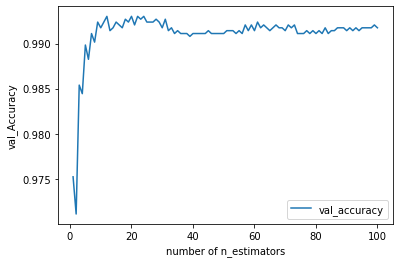

best val Accuracy: 0.9930178694606656
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [561]:
val_accuracy = []  #交叉验证得分
bestAcc = 0.0  #最好的模型的交叉验证得分
best_model=None
xList=np.arange(1,101)
for n in tqdm(xList):
    forest = RandomForestClassifier(n_estimators=n, random_state=0)
    #交叉验证的精确度
    s=np.mean(cross_val_score(forest, X_train, y_train, cv=10))
    val_accuracy.append(s)
    if s>bestAcc:
        bestAcc=s
        best_model=forest
        
plt.figure()
plt.plot(xList,val_accuracy,label='val_accuracy')
plt.legend()
plt.xlabel('number of n_estimators')
plt.ylabel('val_Accuracy')
plt.show();

print('best val Accuracy:',bestAcc)
print(best_model)

In [562]:
RF=best_model
#RF = RandomForestClassifier()
#RF = RandomForestClassifier(n_estimators=35, random_state=0)
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [563]:
#训练数据的 混淆矩阵
predictions = RF.predict(X_train)

cm = confusion_matrix(y_train, predictions, labels=[0,1])
print(cm)
TN, FP, FN, TP = cm.ravel()

# SENSITIVITY = TP / (TP + FN)
Sensitivity = TP / (TP + FN)
print("Sensitivity = "+ str(Sensitivity))

# SPECIFICITY = TN / (FP + TN)
Specificity = TN / (FP + TN)
print("Specificity = "+ str(Specificity))

# Precision = TP / (TP + FP)
Precision = TP / (TP + FP)
print("Precision = "+ str(Precision))

# Accuracy = (TP + TN) / (TP + FP + TN + FN)
Accuracy = (TP + TN) / (TP + FP + TN + FN)
print("Accuracy = "+ str(Accuracy))

[[1892    0]
 [   0 1259]]
Sensitivity = 1.0
Specificity = 1.0
Precision = 1.0
Accuracy = 1.0


In [564]:
#测试数据的 混淆矩阵
predictions = RF.predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=[0,1])
print(cm)
TN, FP, FN, TP = cm.ravel()

# SENSITIVITY = TP / (TP + FN)
Sensitivity = TP / (TP + FN)
print("Sensitivity = "+ str(Sensitivity))

# SPECIFICITY = TN / (FP + TN)
Specificity = TN / (FP + TN)
print("Specificity = "+ str(Specificity))

# Precision = TP / (TP + FP)
Precision = TP / (TP + FP)
print("Precision = "+ str(Precision))

# Accuracy = (TP + TN) / (TP + FP + TN + FN)
Accuracy = (TP + TN) / (TP + FP + TN + FN)
print("Accuracy = "+ str(Accuracy))

[[808   2]
 [ 10 529]]
Sensitivity = 0.9814471243042672
Specificity = 0.9975308641975309
Precision = 0.9962335216572504
Accuracy = 0.9911045218680504


树莓派采集数据验证

In [521]:
# data=pd.read_csv(r'D:\jupyter_work\基于树莓派的跌倒检测系统\all_data.csv')
# df.drop(['mac_SVM','File'],axis=1,inplace=True)
# y=data['label']
# X=data.drop(['File','label'],axis=1)

# predictions = RF.predict(X)
# cm = confusion_matrix(y, predictions, labels=[0,1])
# print(cm)
# TN, FP, FN, TP = cm.ravel()

# # SENSITIVITY = TP / (TP + FN)
# Sensitivity = TP / (TP + FN)
# print("Sensitivity = "+ str(Sensitivity))

# # SPECIFICITY = TN / (FP + TN)
# Specificity = TN / (FP + TN)
# print("Specificity = "+ str(Specificity))

# # Precision = TP / (TP + FP)
# Precision = TP / (TP + FP)
# print("Precision = "+ str(Precision))

# # Accuracy = (TP + TN) / (TP + FP + TN + FN)
# Accuracy = (TP + TN) / (TP + FP + TN + FN)
# print("Accuracy = "+ str(Accuracy))

[[289  36]
 [ 20  85]]
Sensitivity = 0.8095238095238095
Specificity = 0.8892307692307693
Precision = 0.7024793388429752
Accuracy = 0.8697674418604651


In [427]:
#RF.feature_importances_
FI=pd.DataFrame()
FI['feature']=X.columns
FI['importance']=RF.feature_importances_
FI=FI.sort_values(by='importance',ascending=False)
FI

,feature,importance
49,max_VER,0.099291
27,var_SVM,0.080340
13,max_Ay,0.079426
51,range_VER,0.070773
12,median_Ay,0.066985
...,...,...
8,skewness_Ax,0.000822
25,kurtosis_Az,0.000699
55,corr_XZ,0.000564
50,min_VER,0.000336


In [565]:
joblib.dump(RF,'RF_3.pkl')

['RF_3.pkl']